In [1]:
import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [2]:
import numpy as np
import glob
import os

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import ramanspy as rp

import matplotlib.colors as mcolors
from skimage.filters import threshold_yen, threshold_otsu
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [3]:
results_folder = 'results'

### Load data

In [4]:
volume = rp.SpectralVolume.from_image_stack([rp.load.witec(matlab_file) for matlab_file in sorted(glob.glob('raw data/*.mat'))])

preprocessing_pipeline = rp.preprocessing.Pipeline([
    rp.preprocessing.misc.Cropper(region=(700, 1800)),
])

volume_preprocessed = preprocessing_pipeline.apply(volume)

In [5]:
spectral_axis = volume_preprocessed.spectral_axis

### Helper functions

In [6]:
def add_peaks(ax):
    ax.axvline(789, linestyle='--', c='black', zorder=0)
    ax.text(740, .95, 789, transform=ax.get_xaxis_transform())
    ax.axvline(1008, linestyle='--', c='black', zorder=0)
    ax.text(940, .95, 1008, transform=ax.get_xaxis_transform())
    ax.axvline(1066, linestyle='--', c='black', zorder=0)
    ax.text(1040, .95, 1066, transform=ax.get_xaxis_transform())
    ax.axvline(1134, linestyle='--', c='black', zorder=0)
    ax.text(1140, .95, 1134, transform=ax.get_xaxis_transform())
    ax.axvline(1303, linestyle='--', c='black', zorder=0)
    ax.text(1310, .95, 1303, transform=ax.get_xaxis_transform())
    ax.axvline(1443, linestyle='--', c='black', zorder=0)
    ax.text(1450, .95, 1443, transform=ax.get_xaxis_transform())
    ax.axvline(1660, linestyle='--', c='black', zorder=0)
    ax.text(1670, .95, 1660, transform=ax.get_xaxis_transform())

In [68]:
def final_results(endmembers, abundance_maps, selected_components, selected_layer, labels, spectral_axis=None, colors=None, save_to=None, thresholding=False):

    if colors is None:
        cmap = plt.cm.get_cmap()  # using matplotlib's default colormap
        colors = list(cmap(np.linspace(0, 1, len(selected_components))))

    selected_endmembers = [endmembers[i] for i in selected_components]
    selected_abundances = [abundance_maps[i] for i in selected_components]

    plt.figure(figsize=(10, 4))

    ax = rp.plot.spectra(selected_endmembers, spectral_axis, plot_type='single stacked', title=None, color=colors)

    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(selected_components))]
    
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    if save_to is not None:
        os.makedirs(save_to, exist_ok=True)
        plt.savefig(os.path.join(save_to, 'selected_endmembers_no-dashed_lines.png'), dpi=1200, bbox_inches='tight')

    plt.show()


    plt.figure(figsize=(10, 4))

    ax = rp.plot.spectra(selected_endmembers, spectral_axis, plot_type='single stacked', title=None, color=colors)

    add_peaks(ax)

    patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(selected_components))]
    
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    if save_to is not None:
        os.makedirs(save_to, exist_ok=True)
        plt.savefig(os.path.join(save_to, 'selected_endmembers.png'), dpi=1200, bbox_inches='tight')

    plt.show()

    fig, ax = plt.subplots(1, len(selected_abundances), figsize=(32, 5), subplot_kw={'projection': '3d'})
    rp.plot.volume(selected_abundances, ax=list(ax), cbar=False, title=labels, color=colors)

    if save_to is not None:
        plt.savefig(os.path.join(save_to, 'selected_volumes.png'), dpi=1200, bbox_inches='tight')

    plt.show()


    fig, axs = plt.subplots(1, len(selected_abundances), figsize=(25, 4))
    rp.plot.image([ab[..., selected_layer] for ab in selected_abundances], ax=list(axs), cbar=False, title=None, color=colors)

    plt.tight_layout()
    
    if save_to is not None:
        plt.savefig(os.path.join(save_to, 'selected_abundances.png'), dpi=1200, bbox_inches='tight')
        
    plt.show()


    # merged
    
    white = [1, 1, 1, 0]

    fig, ax = plt.subplots()
    for j in range(len(selected_components)):        
        cmap = LinearSegmentedColormap.from_list('', [white, colors[j]])        
        
        ax.imshow(selected_abundances[j][..., selected_layer], cmap=cmap)

    ax.axis('off')
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    if save_to is not None:
        plt.savefig(os.path.join(save_to, 'selected_abundances_merged.png'), dpi=1200)
        
        
    plt.show()


    fig, ax = plt.subplots()
    for j in range(len(selected_components)):
        cmap = LinearSegmentedColormap.from_list('', [white, colors[j]])

        ax.imshow(selected_abundances[j][..., selected_layer], cmap=cmap, vmin=0, vmax=1)

    ax.axis('off')
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    if save_to is not None:
        plt.savefig(os.path.join(save_to, 'selected_no-norm_abundances_merged.png'), dpi=1200)


    plt.show()
       

    if thresholding:
        selected_abundances_ = []
        for amap in selected_abundances:

            amap_ = np.array(amap, copy=True) 
            thresh = threshold_otsu(amap_)
            print(thresh)
            amap_[amap_ <= thresh] = 0
            
            selected_abundances_.append(amap_.reshape(amap.shape))
            
        selected_abundances = list(np.array(selected_abundances_, copy=True))


    fig, ax = plt.subplots(1, len(selected_abundances), figsize=(32, 5), subplot_kw={'projection': '3d'})
    rp.plot.volume(selected_abundances, ax=list(ax), cbar=False, title=labels, color=colors)

    if save_to is not None:
        plt.savefig(os.path.join(save_to, 'selected_volumes_otsu.png'), dpi=1200, bbox_inches='tight')

    plt.show()


    fig, axs = plt.subplots(1, len(selected_abundances), figsize=(25, 4))
    rp.plot.image([ab[..., selected_layer] for ab in selected_abundances], ax=list(axs), cbar=False, title=None, color=colors)

    plt.tight_layout()

    if save_to is not None:
        plt.savefig(os.path.join(save_to, 'selected_abundances_otsu.png'), dpi=1200, bbox_inches='tight')

    plt.show()


    white = [1, 1, 1, 0]

    fig, ax = plt.subplots()
    for j in range(len(selected_components)):        
        cmap = LinearSegmentedColormap.from_list('', [white, colors[j]])        
        
        ax.imshow(selected_abundances[j][..., selected_layer], cmap=cmap)

    ax.axis('off')
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    if save_to is not None:
        plt.savefig(os.path.join(save_to, 'selected_abundances_merged_otsu.png'), dpi=1200)
        
        
    plt.show()

In [9]:
def get_data(model_folder):
    endmembers = np.load(f'{results_folder}/{model_folder}/endmembers.npy')
    abundances = np.load(f'{results_folder}/{model_folder}/abundance_maps.npy')
    
    return endmembers, abundances

# VCA + NNLS

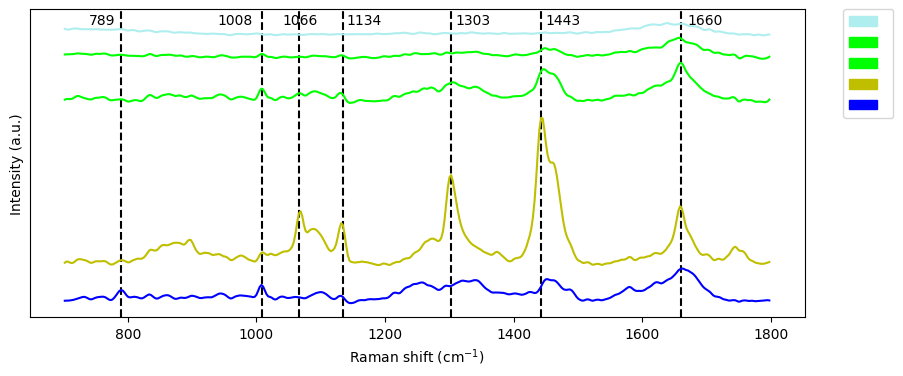

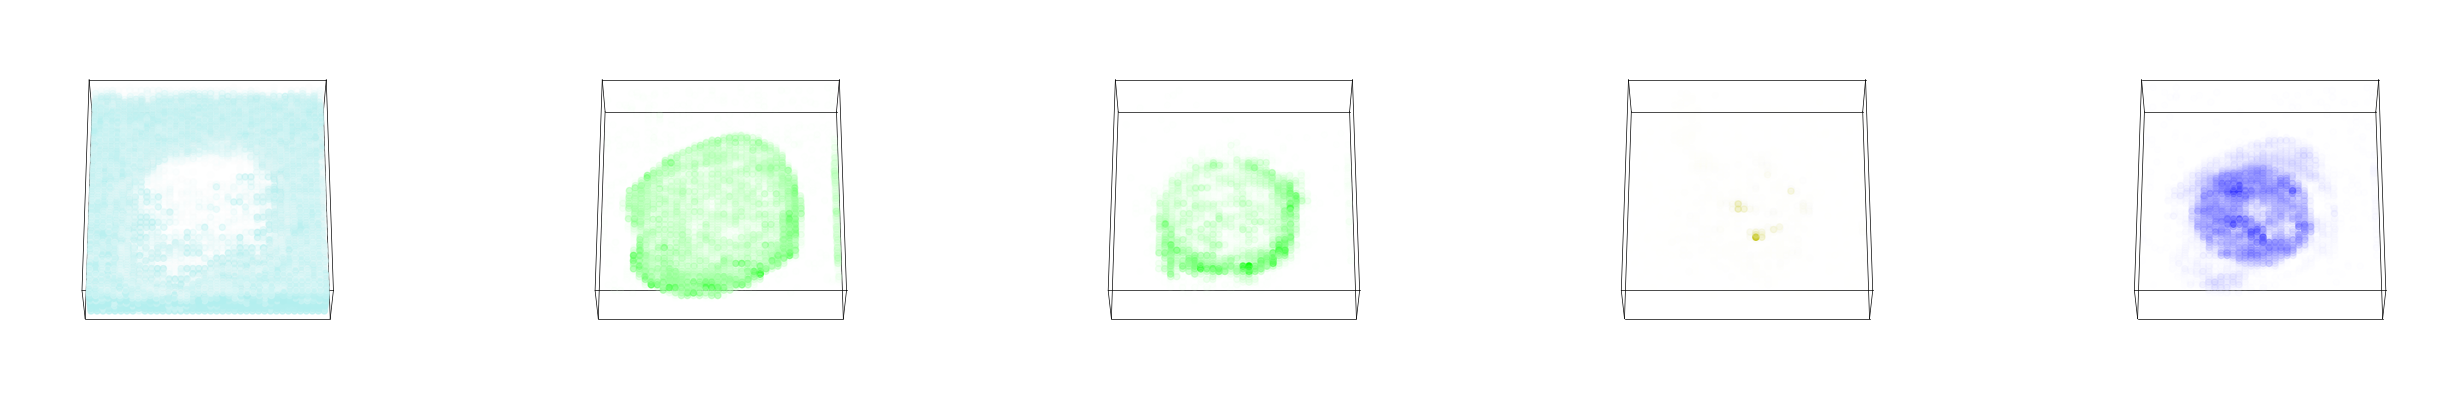

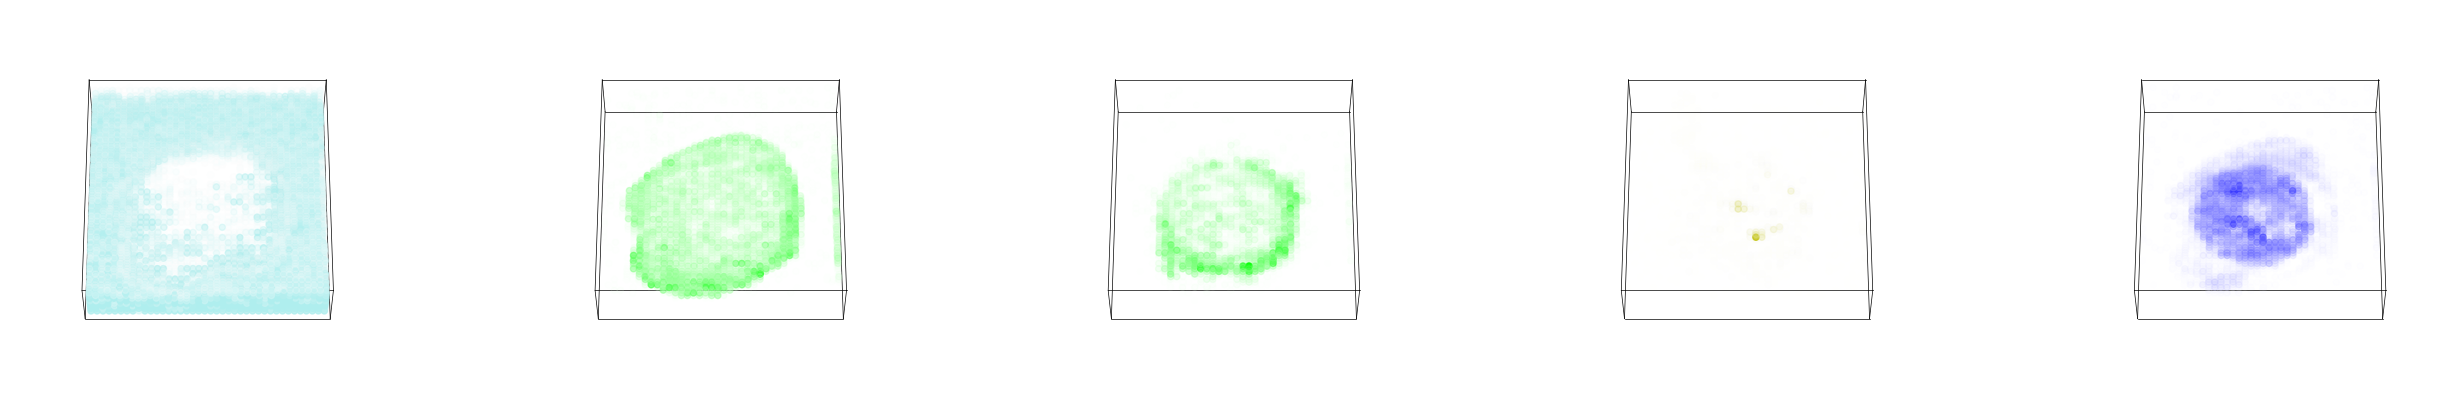

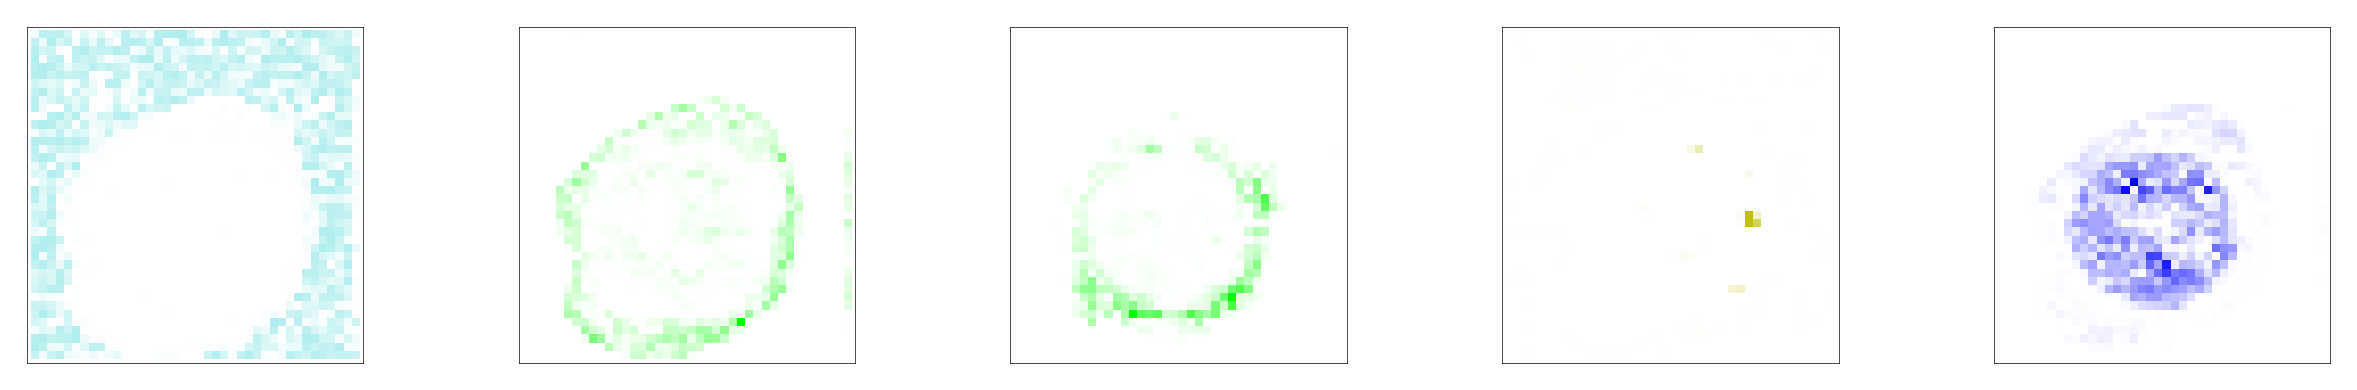

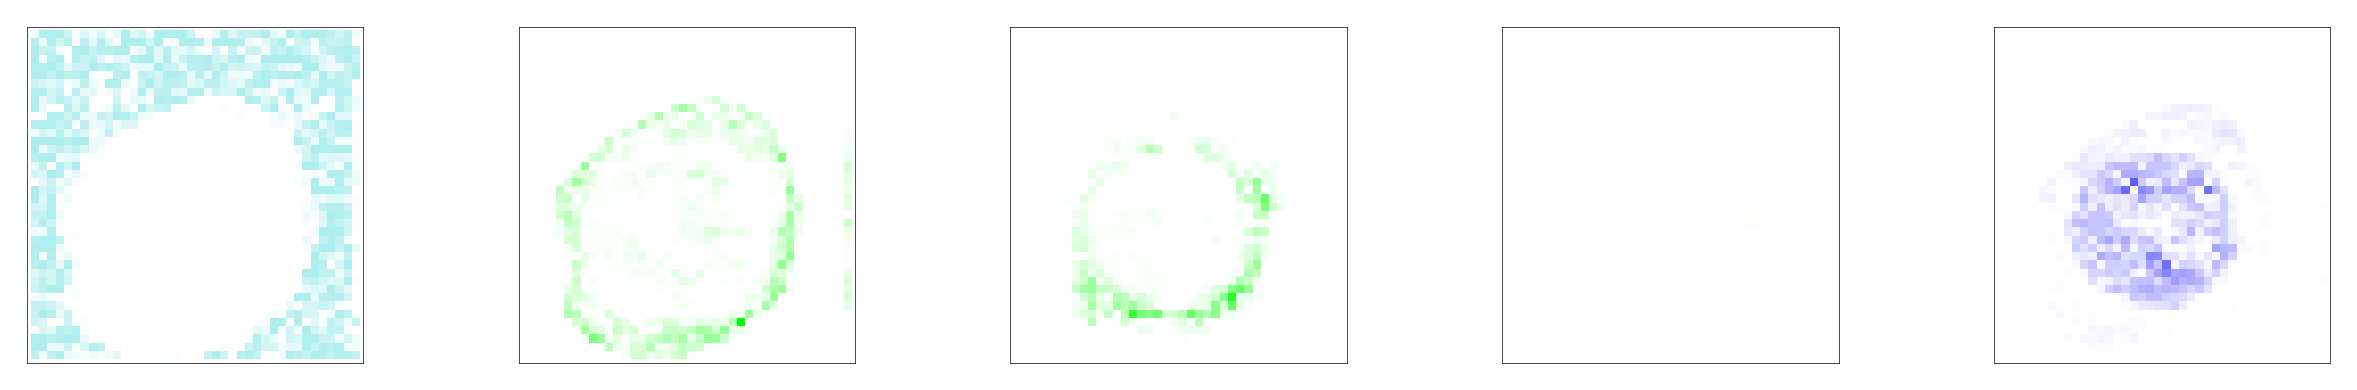

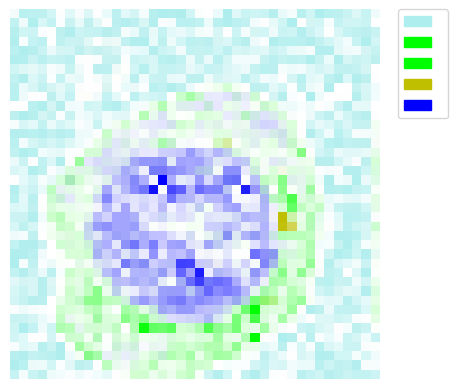

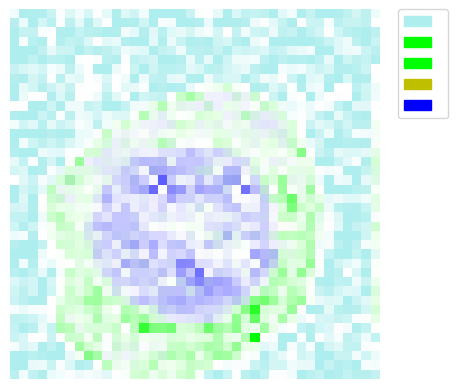

0.48979858
0.1617229
0.16200173
0.16978917
0.19707642


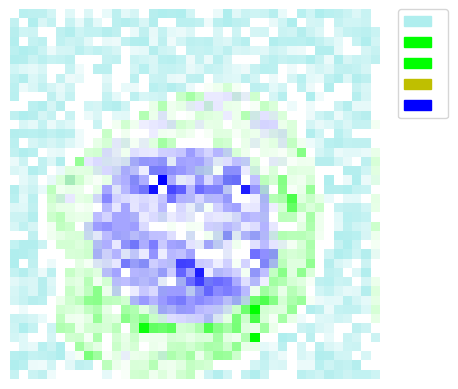

In [56]:
model_folder = 'vca'

endmembers, abundances = get_data(model_folder)
final_results(endmembers, abundances, [5, 18, 6, 4, 12], 6, labels=['']*5, colors=['paleturquoise', 'lime', 'lime', 'y', 'blue'], spectral_axis=spectral_axis, thresholding=True, save_to=f'{results_folder}/{model_folder}')

# Dense AE

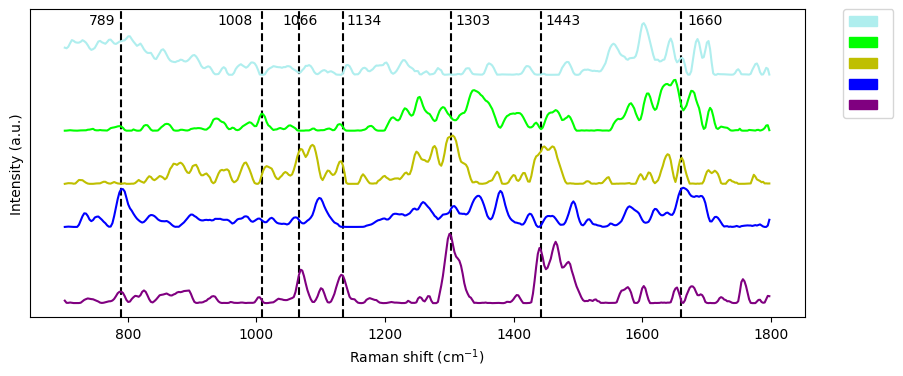

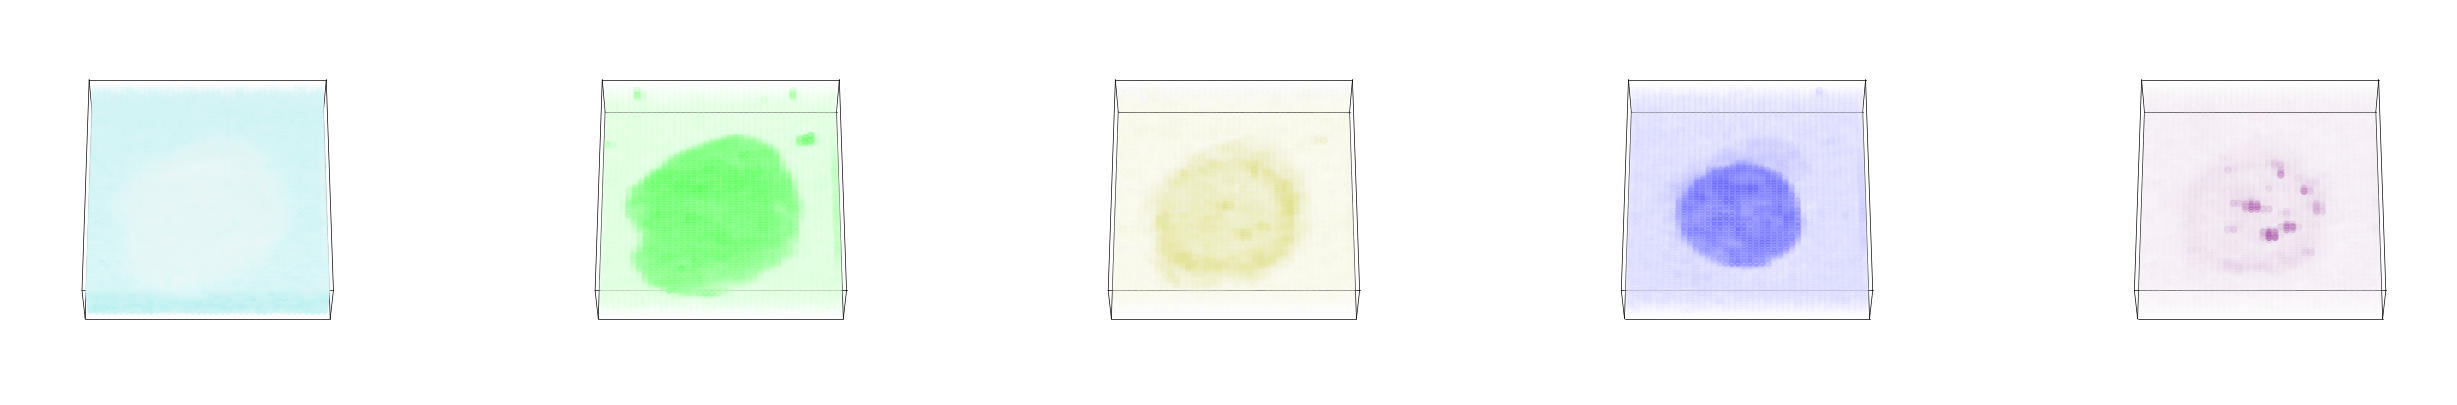

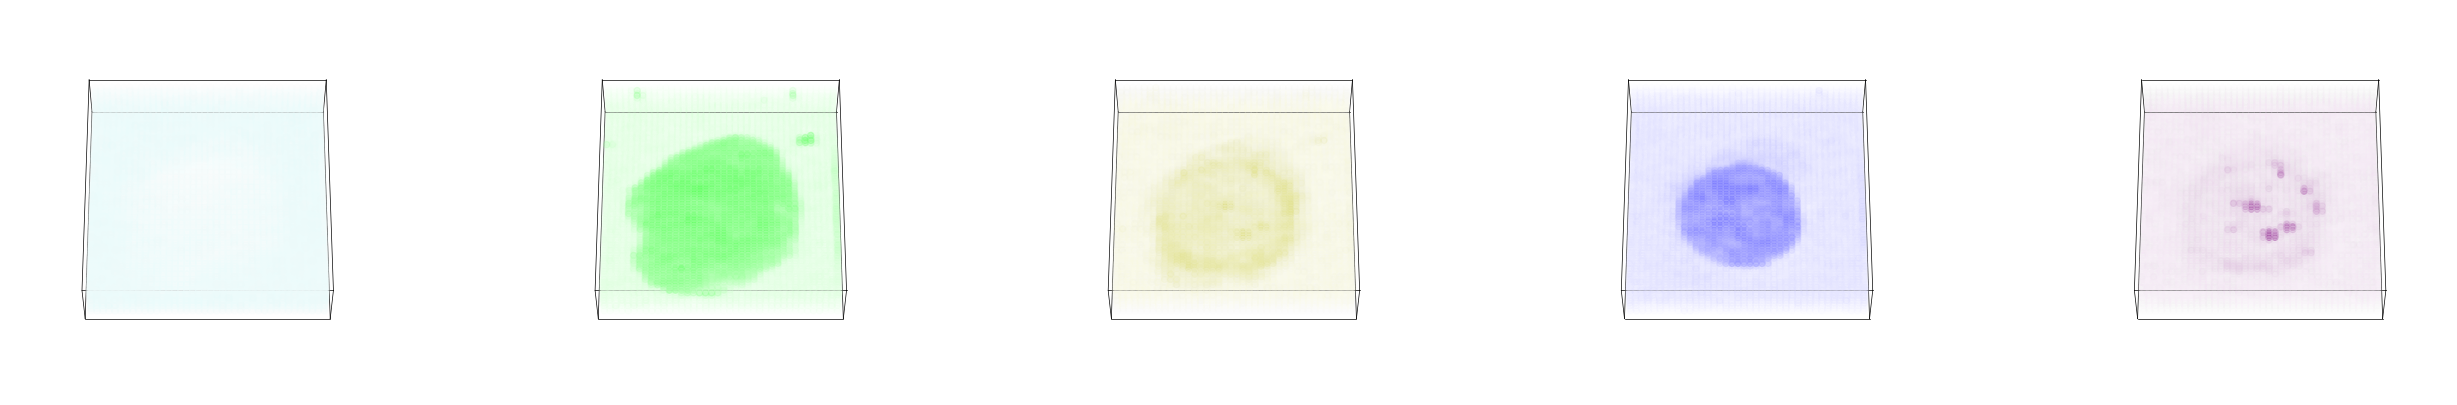

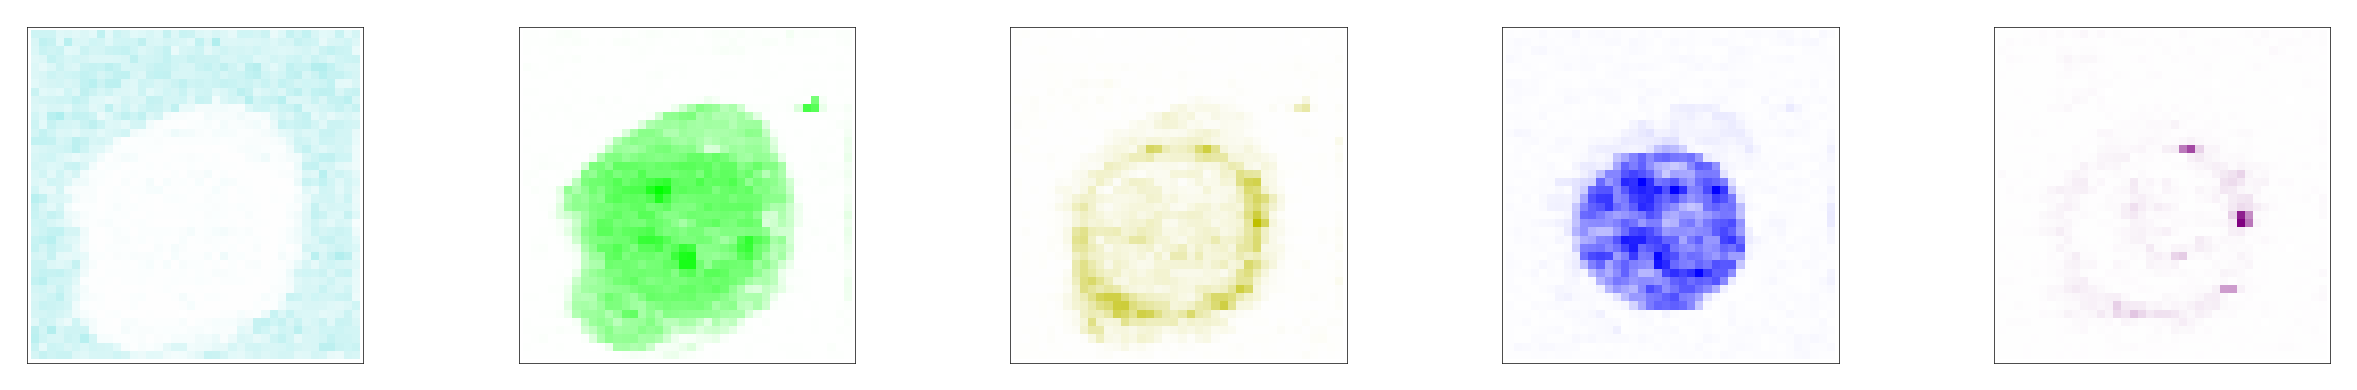

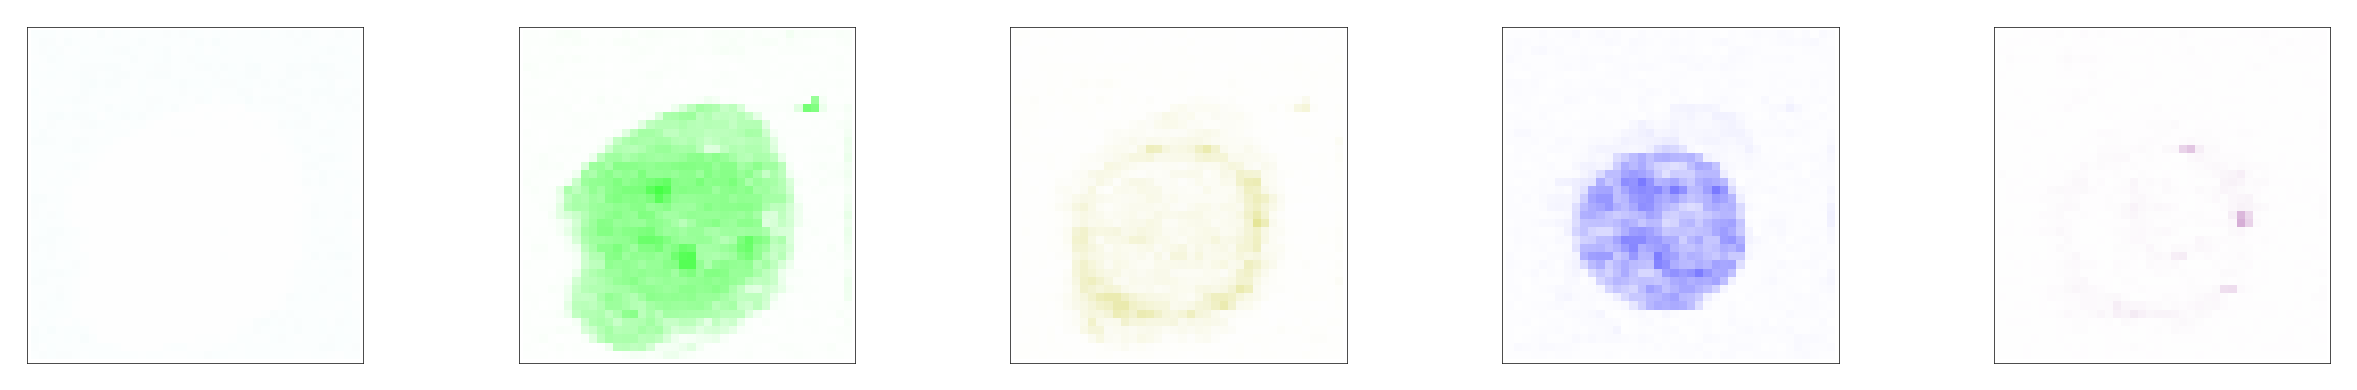

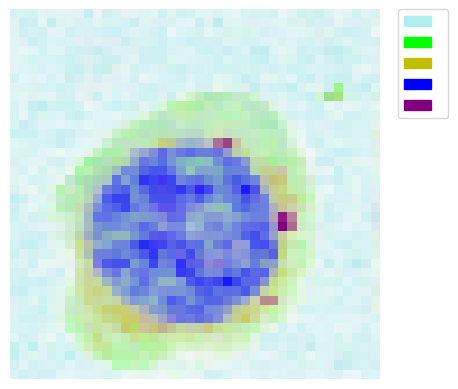

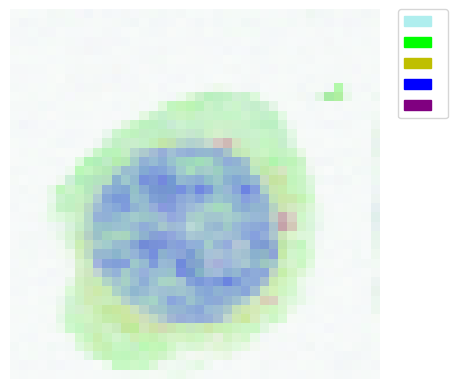

0.15297867
0.32491985
0.17718773
0.2853671
0.31318557


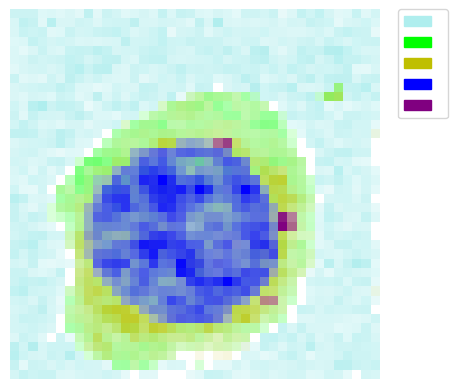

In [42]:
model_folder = 'dense_ae_linear'

endmembers, abundances = get_data(model_folder)
final_results(endmembers, abundances, [18, 16, 17, 19, 11], 6, labels=['']*5, colors=['paleturquoise', 'lime', 'y', 'blue', 'purple' ], spectral_axis=spectral_axis, thresholding=True, save_to=f'{results_folder}/{model_folder}')

# Deep Dense AE

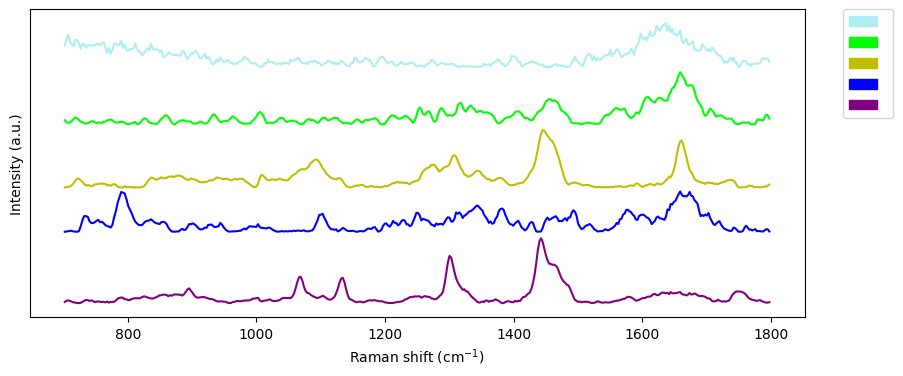

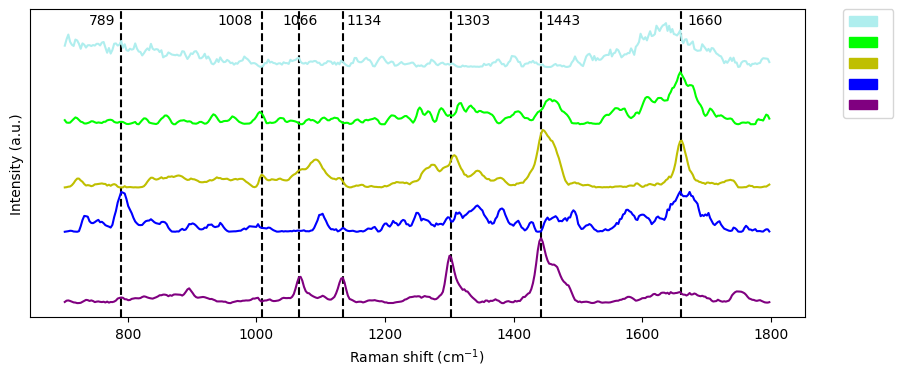

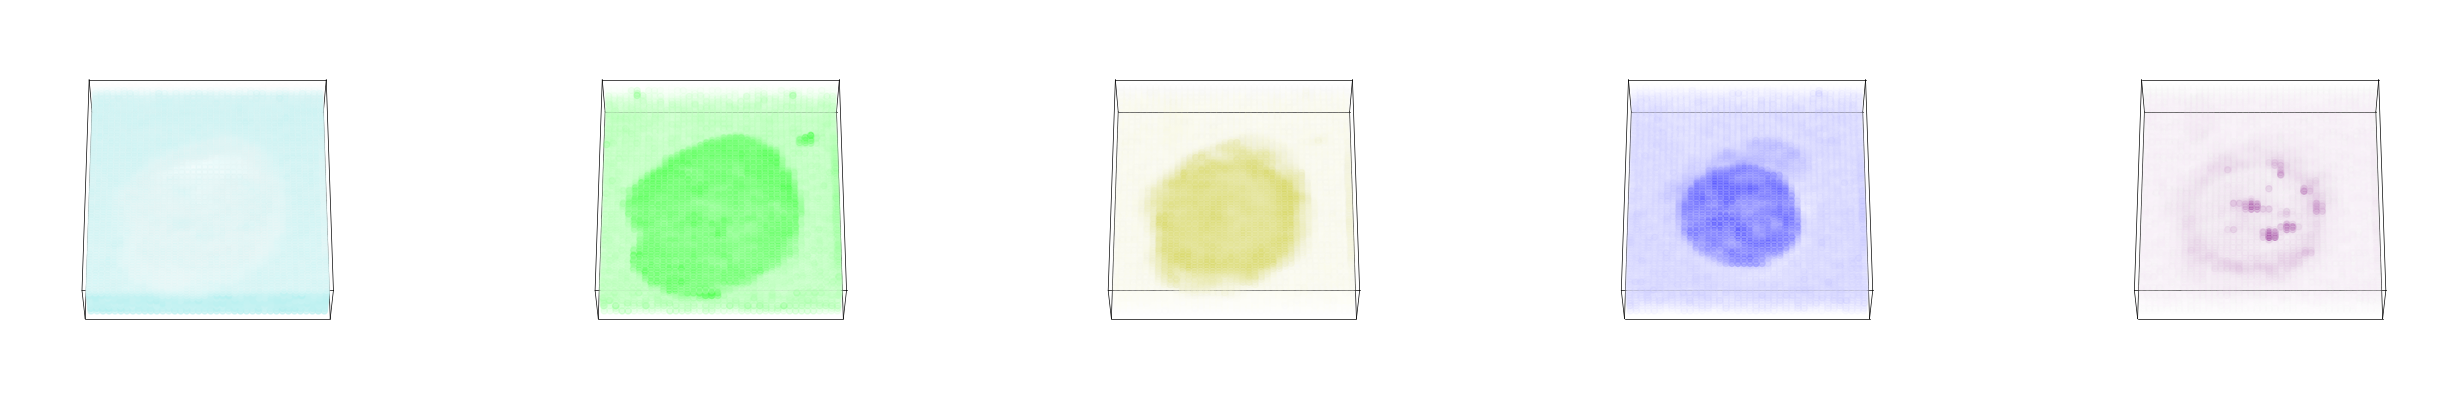

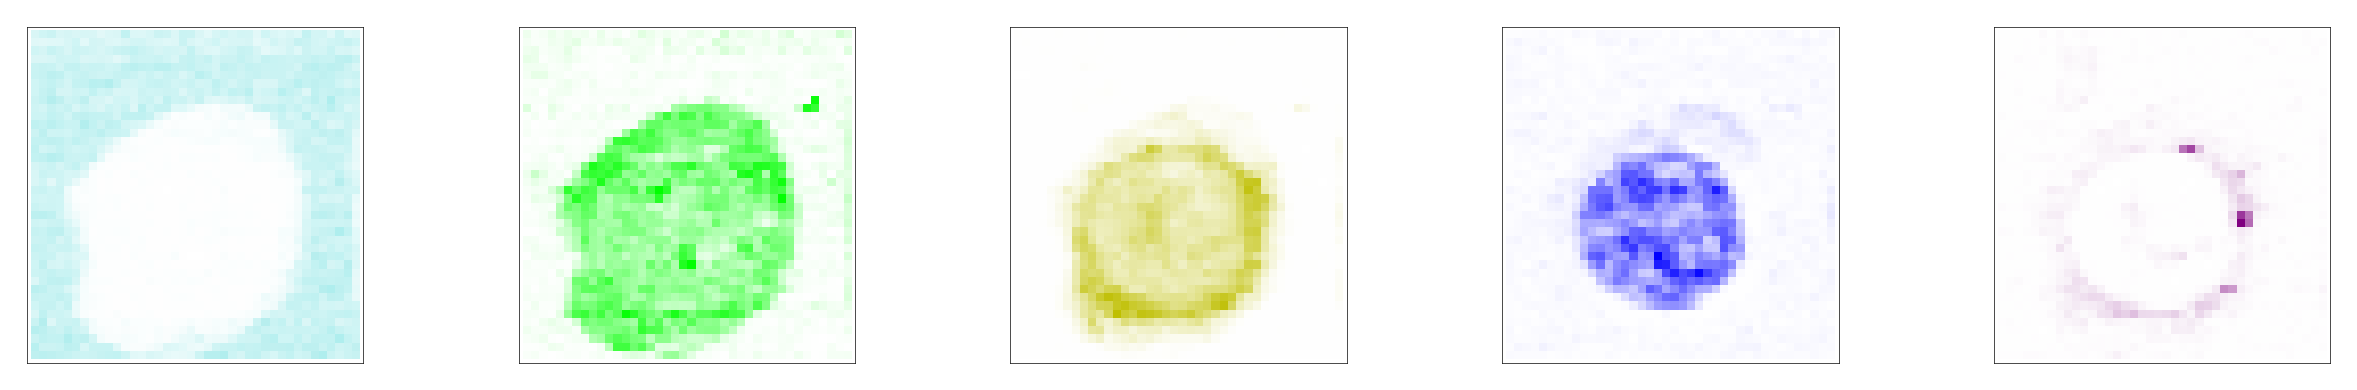

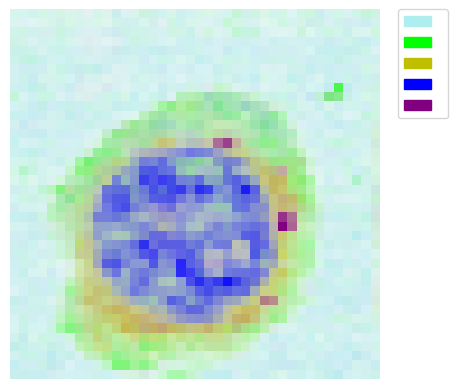

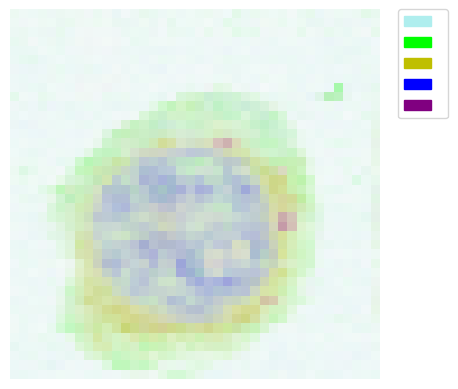

0.23513748
0.30435854
0.2554232
0.21443942
0.101164095


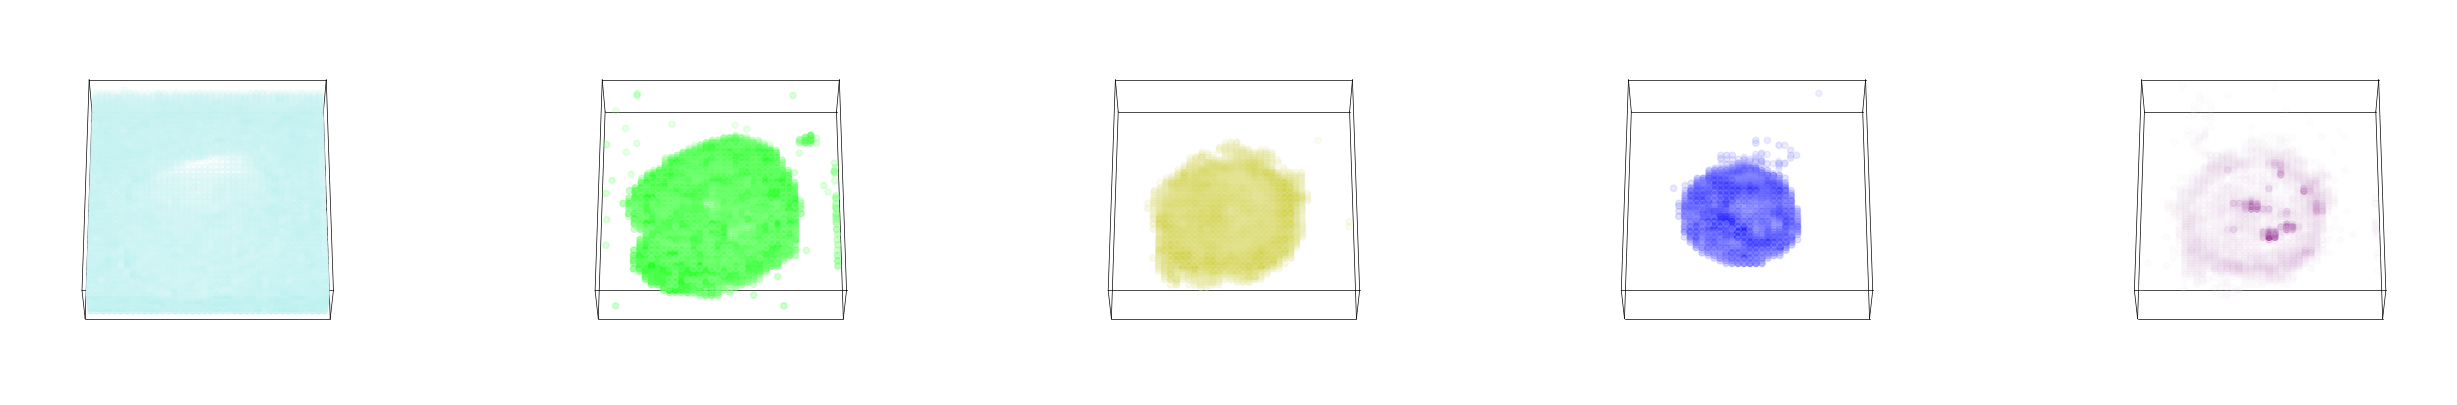

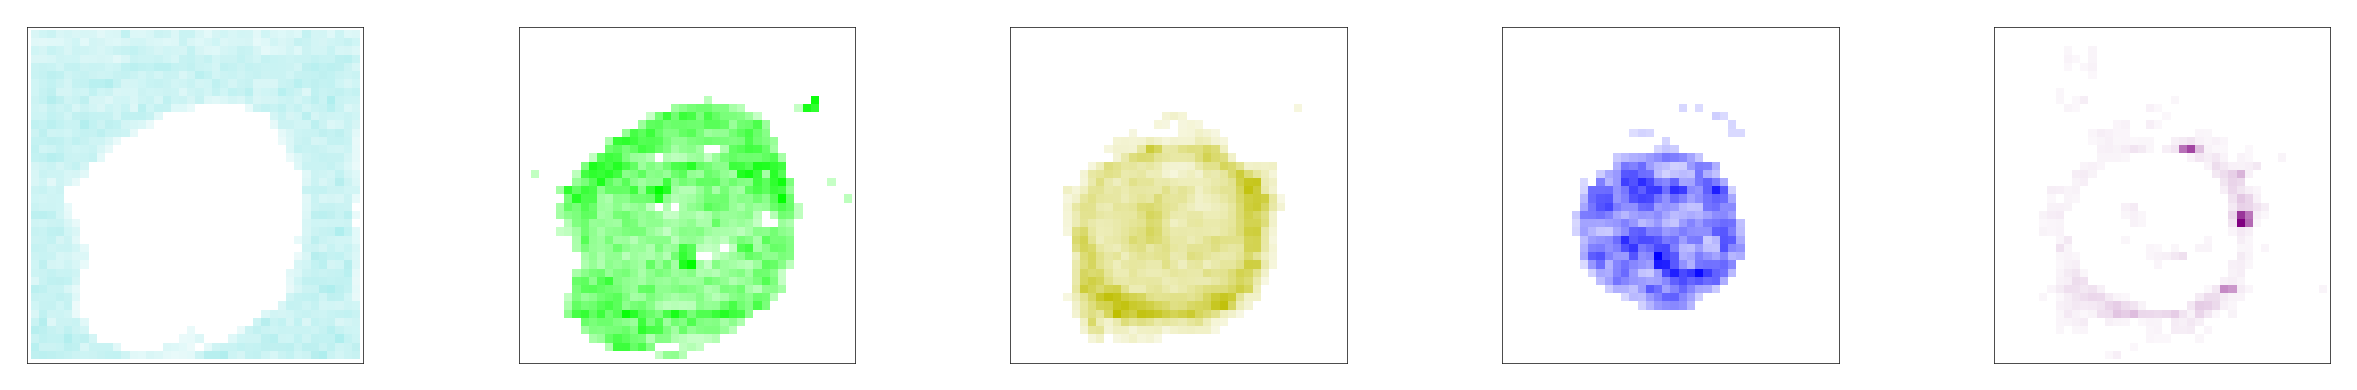

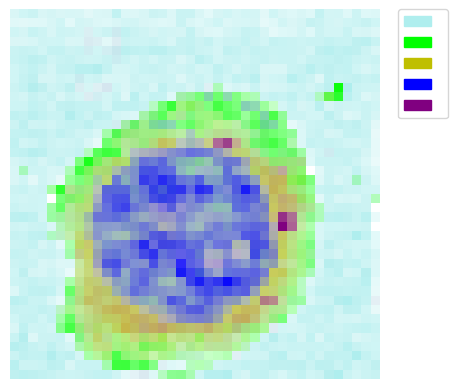

In [69]:
model_folder = 'deep_dense_ae_linear'

endmembers, abundances = get_data(model_folder)
final_results(endmembers, abundances, [7, 18, 19, 2, 3], 6, labels=['']*5, colors=['paleturquoise', 'lime', 'y', 'blue', 'purple'], spectral_axis=spectral_axis, thresholding=True, save_to=f'{results_folder}/{model_folder}')

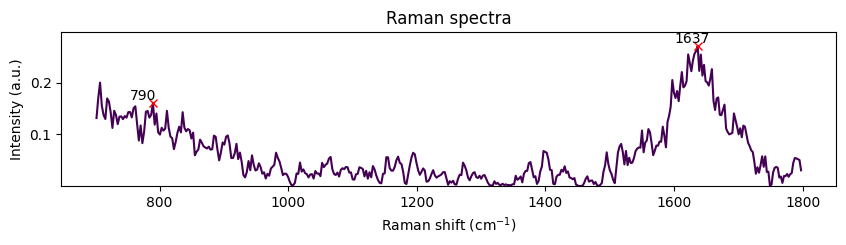

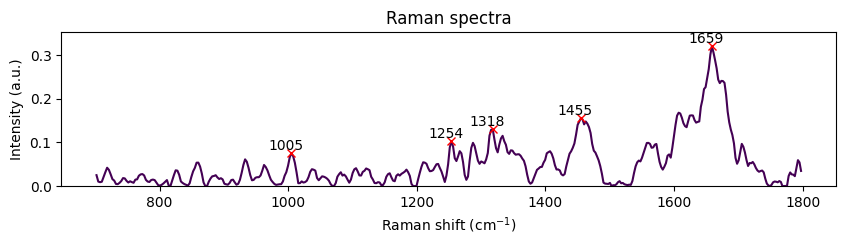

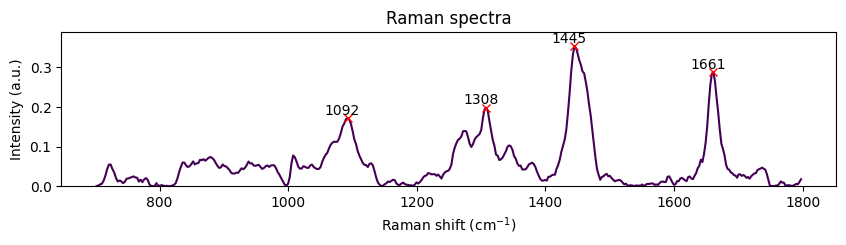

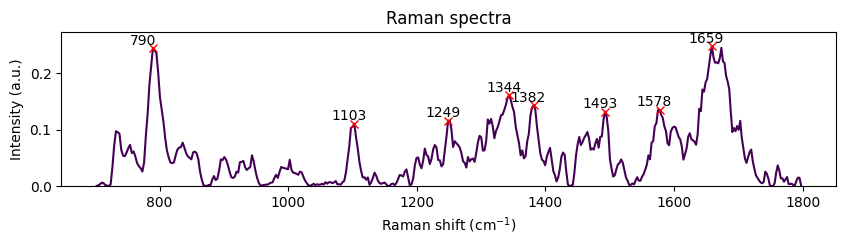

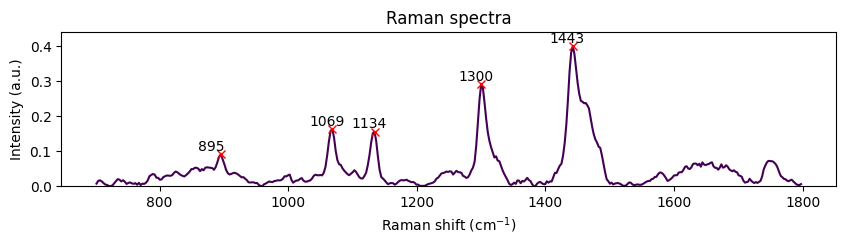

In [79]:

selected_components = [7, 18, 19, 2, 3]
selected_endmembers = [rp.Spectrum(endmembers[i], spectral_axis)  for i in selected_components]

for endmember in selected_endmembers:
    plt.figure(figsize=(10, 2))
    rp.plot.peaks(endmember, prominence=0.075)
    plt.show()

In [82]:
def plot_species(species, offset=0, **plt_kwargs):
    if not isinstance(species, list):
        species = [species]

    for datum in species:
        intensity_stack, shift_axis = datum if isinstance(datum, tuple) else (datum, None)
        plt.plot(shift_axis, (intensity_stack.reshape(-1, intensity_stack.shape[-1]) + offset).T, **plt_kwargs)

In [113]:
def offset_plot(spectra, *, wavenumber_axis=None, ax=None,
                label=None, color=None, title=None, xlabel=None, ylabel=None, **kwargs):
    genus_data = []
    for species in spectra:
        if isinstance(species, list):
            species_data = [
                (species_obj.spectral_data, species_obj.spectral_axis) if hasattr(species_obj, "spectral_data") else (
                species_obj, wavenumber_axis) for species_obj in species]
            genus_data.append(species_data)
        else:
            genus_data.append((species.spectral_data, species.spectral_axis) if hasattr(species, "spectral_data") else (
            species, wavenumber_axis))


    if ax is None:
        ax = plt.gca()

    offset = 0
    for species, color_, label_ in zip(genus_data, color, label):
        if isinstance(species, list):
            intensity_stacks = [spectral_data[0] if isinstance(spectral_data, tuple) else spectral_data for
                                spectral_data in species]
            species_max_value = max(np.max(intensity_stack) for intensity_stack in intensity_stacks)
            species_min_value = min(np.min(intensity_stack) for intensity_stack in intensity_stacks)
        else:
            species_max_value = np.max(species[0] if isinstance(species, tuple) else species)
            species_min_value = np.min(species[0] if isinstance(species, tuple) else species)

        offset -= 0.6

        plot_species(species, offset=offset, color=color_, label=label_, **kwargs)

        offset += species_min_value

    if any(label):
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
        plt.subplots_adjust(right=0.7)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_yticks([])

    return ax

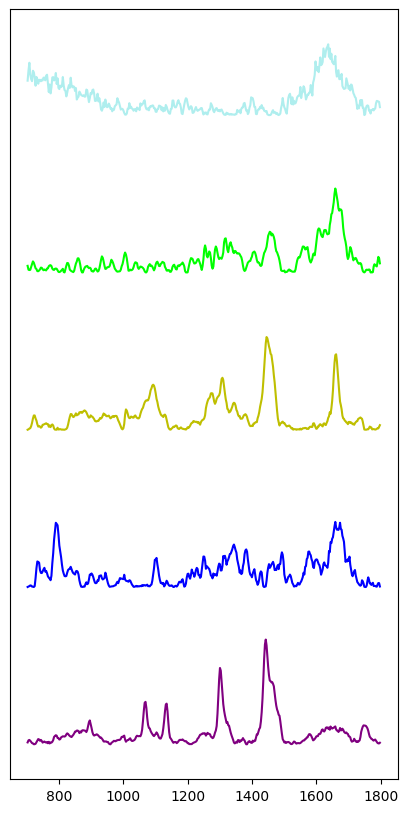

In [114]:
plt.figure(figsize=(5, 10))
offset_plot(selected_endmembers, color=['paleturquoise', 'lime', 'y', 'blue', 'purple'], label=['']*5)

plt.savefig(f'{results_folder}/{model_folder}/selected_endmembers_vertical.png', bbox_inches='tight', dpi=1200)